# Predictor de Arqueotipos de Mazo de Hearthstone

**Autores:** Jorge Fatama Vera (Entrenamiento del Sistema de Predicción) y Sergio Cama Chávez (Servicio Web).<br>
**Universidad:** Pontificia Universidad Católica del Perú, Lima, Perú.<br>
**Curso:** *Curso de Capacitación en Deep Learning 2018-01*.<br>
**Con colaboración de:** Grupo de Inteligencia Artificial (IA-PUCP) & Sociedad de Apoyo para Informáticos (SAI-PUCP).

<img src="logo-hearthstone.png">

## Sustentación del Proyecto

En Kaggle se encontró un dataset llamado "History of Hearthstone", perteneciente al usuario *romainvincent*, el cual contiene, hasta su última actualización, alrededor de 3 mil cartas (en el archivo *refs.json*) y 300 mil mazos subidos a la conocida página *Hearthpwn* (en el archivo *data.csv*). Sin embargo, en ambos archivos se encuentran datos irrelevantes:<br>
- **Con respecto a los mazos**, sólo utilizaremos los mazos pertenecientes al modo clasificatorio y los utilizados en torneos oficiales de *Hearthstone* del formato estándar. Además, hay parámetros que no necesitamos para la predición, como la fecha en la que se subieron a *Hearthpwn* o el seudónimo del usuario que subió el mazo.<br>
- **Con respecto a las cartas**, sólo utilizaremos las cartas coleccionables, las cuales son las únicas que se pueden utilizar en los mazos válidos. Además, hay parámetros que no necesitamos para la predición, como la descripción de la carta en la colección o la explicación de cómo obtener una copia de la carta en versión dorada.<br>

El objetivo del proyecto es resolver uno de los cuatro problemas planteados por *romainvincent* en la descripción de su dataset: predecir el arqueotipo de un mazo basado en las características de las cartas contenidas en éste. Para lograr este objetivo, se ha utilizado, como método de Aprendizaje de Máquina, el conocido *RandomForestClassifier*.<br><br>
Como parte de un producto final, se implementó un servicio web que, habiendo recibido las treinta (30) cartas de un mazo, predice cuál es el arqueotipo al que más se ajusta.

## Parte 1: Exploración, limpieza y pre-procesamiento de los datos

In [1]:
#Librerías utilizadas más frecuentemente
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Parte 1.1: Extracción de los datos de las cartas

La información que respecta a las cartas del juego se encuentran en un objeto JSON llamado *cards.json* (en el dataset original se llama *refs.json*). Se procederá a cargar a memoria el objeto y a dar un vistazo a las características de sus parámetros.

In [2]:
#Leemos el JSON de las cartas
df_cards = pd.read_json("Data/cards.json")

print(df_cards.info())
df_cards.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3117 entries, 0 to 3116
Data columns (total 32 columns):
artist                1527 non-null object
attack                1431 non-null float64
cardClass             3114 non-null object
classes               9 non-null object
collectible           1206 non-null float64
collectionText        12 non-null object
cost                  2420 non-null float64
dbfId                 3116 non-null float64
durability            71 non-null float64
elite                 353 non-null float64
entourage             58 non-null object
faction               72 non-null object
flavor                1193 non-null object
health                1539 non-null float64
hideStats             20 non-null float64
howToEarn             245 non-null object
howToEarnGolden       290 non-null object
id                    3117 non-null object
mechanics             1061 non-null object
multiClassGroup       9 non-null object
name                  3116 non-null object
o

,artist,attack,cardClass,classes,collectible,collectionText,cost,dbfId,durability,elite,...,playRequirements,playerClass,race,rarity,referencedTags,set,spellDamage,targetingArrowText,text,type
0,Jakub Kasper,4.0,NEUTRAL,NaN,1.0,NaN,4.0,2518.0,NaN,NaN,...,NaN,NEUTRAL,NaN,EPIC,[BATTLECRY],TGT,NaN,NaN,Whenever you play a card with <b>Battlecry</b>...,MINION
1,NaN,4.0,NEUTRAL,NaN,NaN,NaN,6.0,1769.0,NaN,1.0,...,NaN,NEUTRAL,NaN,LEGENDARY,NaN,CREDITS,NaN,NaN,<b>Battlecry:</b> Draw some cards. With a pen.,MINION
2,NaN,NaN,NEUTRAL,NaN,NaN,NaN,NaN,10081.0,NaN,NaN,...,NaN,NEUTRAL,NaN,NaN,NaN,TB,NaN,NaN,Attack and Health have been swapped by Deviate...,ENCHANTMENT
3,Mauricio Herrera,3.0,WARRIOR,NaN,1.0,NaN,3.0,40569.0,NaN,NaN,...,NaN,WARRIOR,NaN,RARE,NaN,GANGS,NaN,NaN,<b>Battlecry:</b> Give a random weapon in your...,MINION
4,Ittoku,2.0,NEUTRAL,NaN,1.0,NaN,4.0,1370.0,NaN,NaN,...,NaN,NEUTRAL,BEAST,FREE,NaN,CORE,NaN,NaN,NaN,MINION


El objeto JSON que almacena la información de las cartas contiene 32 parámetros, de los cuales la mayoría no nos servirán para cumplir nuestro objetivo. Luego de un análisis previo, se determinó que sólo mantendríamos 11 parámetros, los cuales algunos nos servirán para la predicción más adelante y los demás para cuestiones del análisis exploratorio de datos. A continuación se describirán los parámetros relevantes para la predicción.

### Parámetros relevantes (en orden alfabético)

- **collectible**: Bandera que indica si la carta es coleccionable. Es decir, si se puede conseguir en sobres de su respectiva expansión/aventura y/o comprar con polvo arcano.
- **id** (antes dbfId): Identificador de la carta que se usará para identificar su uso en los mazos.
- **playerClass**: Clase a la que corresponde la carta (puede ser neutral o cualquiera de las 9 clases disponibles).
- **race**: Raza del esbirro (ej: 'ELEMENTAL', 'MECH', 'MURLOC').
- **rarity**: Rareza de la carta: ['FREE','COMMON','RARE','EPIC','LEGENDARY']
- **type**: Tipo de carta: ['MINION','SPELL','WEAPON','HERO']. Para este proyecto sólo se usarán los tres primeros, puesto que la época de la última actualización del dataset aún no salían las cartas héroe.

In [3]:
#Eliminamos los parámetros no relevantes
df_cards.drop('artist', axis=1, inplace=True) #Nombre del artista
df_cards.drop('flavor', axis=1, inplace=True) #Descripción de la carta en la colección
df_cards.drop('referencedTags', axis=1, inplace=True) #Etiquetas referenciales
df_cards.drop('elite', axis=1, inplace=True) #Bandera que indica si son cartas élite o no (todas las marcadas son legendarias)
df_cards.drop('id', axis=1, inplace=True) #Id por set (no se usa en los mazos)
df_cards.drop('hideStats', axis=1, inplace=True) #Bandera que define si se muestra la salud y el ataque
df_cards.drop('howToEarn', axis=1, inplace=True) #Descripción de cómo ganar una a dos copias de la carta
df_cards.drop('howToEarnGolden', axis=1, inplace=True) #Descripción de cómo ganar una a dos copias de la carta en dorado
df_cards.drop('faction', axis=1, inplace=True) #¿El personaje simpatiza con la Alianza o la Horda?
df_cards.drop('targetingArrowText', axis=1, inplace=True) #Texto que aparece cuando se va a seleccionar un objetivo
df_cards.drop('overload', axis=1, inplace=True) #Sobrecarga (cristales de maná bloquedos para el siguiente turno. Se sobreen-
                                                #tiende en el texto)
df_cards.drop('collectionText', axis=1, inplace=True) #Texto alternativo
df_cards.drop('playRequirements', axis=1, inplace=True) #Requisitos para jugar la carta
df_cards.drop('classes', axis=1, inplace=True) #Caso para las cartas tri-clase
df_cards.drop('multiClassGroup', axis=1, inplace=True) #Caso para las cartas tri-clase
df_cards.drop('entourage', axis=1, inplace=True)
#df_cards.drop('collectible', axis=1, inplace=True) #Bandera que define si la carta es coleccionable. Se sobreentiende
df_cards.drop('attack', axis=1, inplace=True) #
df_cards.drop('health', axis=1, inplace=True) #
df_cards.drop('durability', axis=1, inplace=True) #
df_cards.drop('spellDamage', axis=1, inplace=True) #
df_cards.drop('text', axis=1, inplace=True) #

df_cards.rename(columns={'dbfId':'id'}, inplace=True)
df_cards['id'].fillna(0, inplace=True) #Eliminar después
df_cards['id'] = df_cards['id'].astype(int)
df_cards['cost'].fillna(0, inplace=True)
df_cards['cost'] = df_cards['cost'].astype(int)
df_cards['collectible'].fillna(False, inplace=True)
df_cards['collectible'] = df_cards['collectible'].astype(bool)

#Actualizamos el índice de cada registro
df_cards.index = np.arange(0, len(df_cards))

print(df_cards.info())
df_cards.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117 entries, 0 to 3116
Data columns (total 11 columns):
cardClass      3114 non-null object
collectible    3117 non-null bool
cost           3117 non-null int32
id             3117 non-null int32
mechanics      1061 non-null object
name           3116 non-null object
playerClass    3114 non-null object
race           435 non-null object
rarity         1598 non-null object
set            3116 non-null object
type           3116 non-null object
dtypes: bool(1), int32(2), object(8)
memory usage: 246.6+ KB
None


,cardClass,collectible,cost,id,mechanics,name,playerClass,race,rarity,set,type
0,NEUTRAL,True,4,2518,NaN,Crowd Favorite,NEUTRAL,NaN,EPIC,TGT,MINION
1,NEUTRAL,False,6,1769,NaN,Ben Thompson,NEUTRAL,NaN,LEGENDARY,CREDITS,MINION
2,NEUTRAL,False,0,10081,NaN,Deviate Switch,NEUTRAL,NaN,NaN,TB,ENCHANTMENT
3,WARRIOR,True,3,40569,[BATTLECRY],Grimestreet Pawnbroker,WARRIOR,NaN,RARE,GANGS,MINION
4,NEUTRAL,True,4,1370,NaN,Oasis Snapjaw,NEUTRAL,BEAST,FREE,CORE,MINION


## MAZOS

### Parámetros relevantes

In [4]:
#Leemos el CSV de las mazos
df_decks = pd.read_csv('Data/decks.csv')

In [5]:
#Sólo nos interesan los mazos de formato normal (sólo Estándar y Salvaje)
df_decks = df_decks[(df_decks.deck_type == 'Ranked Deck') | (df_decks.deck_type == 'Tournament')]
df_decks = df_decks[df_decks.deck_format == 'S']

In [6]:
#Eliminamos los parámetros no relevantes
df_decks.drop('deck_type', axis=1, inplace=True) #Tipo de mazo. Todos son mazos competitivos
df_decks.drop('deck_format', axis=1, inplace=True) #Tipo de formato de juego. Todos son mazos estándar
df_decks.drop('deck_id', axis=1, inplace=True) #Id del mazo. No es relevante
df_decks.drop('date', axis=1, inplace=True) #Fecha de subida del mazo. No es relevante.
df_decks.drop('user', axis=1, inplace=True) #Usuario del mazo
#df_decks.drop('title', axis=1, inplace=True) #Nombre del mazo del mazo
df_decks.drop('rating', axis=1, inplace=True) #Puntuación del mazo

#Actualizamos el índice de cada registro
df_decks.index = np.arange(0, len(df_decks))

print(df_decks.info())
df_decks.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103891 entries, 0 to 103890
Data columns (total 35 columns):
craft_cost        103891 non-null int64
deck_archetype    103891 non-null object
deck_class        103891 non-null object
deck_set          103891 non-null object
title             103890 non-null object
card_0            103891 non-null int64
card_1            103891 non-null int64
card_2            103891 non-null int64
card_3            103891 non-null int64
card_4            103891 non-null int64
card_5            103891 non-null int64
card_6            103891 non-null int64
card_7            103891 non-null int64
card_8            103891 non-null int64
card_9            103891 non-null int64
card_10           103891 non-null int64
card_11           103891 non-null int64
card_12           103891 non-null int64
card_13           103891 non-null int64
card_14           103891 non-null int64
card_15           103891 non-null int64
card_16           103891 non-null int64
card_

,craft_cost,deck_archetype,deck_class,deck_set,title,card_0,card_1,card_2,card_3,card_4,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
0,0,Unknown,Mage,Explorers,Beginners Spelldamage Mage,77,77,90,90,175,...,662,662,672,672,906,906,1004,1004,1084,1084
1,5180,Unknown,Rogue,Explorers,Weazelbuster's Storm Rogue (Standard),180,180,365,365,459,...,1029,1064,1117,1117,1158,1158,268,556,2884,2884
2,6260,Unknown,Druid,Explorers,Ramp Druid,64,64,95,137,137,...,2598,2598,2736,2782,2782,2919,38113,38113,38319,38319
3,7980,Fatigue Mage,Mage,Explorers,K-DOG's Malygos Fatigue Mage: Wrecker of Contr...,138,138,172,172,395,...,1016,2262,2874,2875,2901,2901,2949,36111,39225,39840
4,1480,Mill Rogue,Rogue,Explorers,Mill Rogue Revived! (K-DOG),180,180,196,196,365,...,2291,2304,2304,2704,2883,2949,2951,38578,39313,39491


In [7]:
#Hay algunas cartas cuyo nombre coincide con algunas cartas de aventuras, que accidentalmente heredaron el ID de las no coleccio-
#nales, por lo que debemos buscarlas y reemplazarlas con sus verdaderos IDs

def replace_ambiguities():
    print('Processing',len(df_decks))
    #for i in range(1000):
    for i in range(len(df_decks)):
        deckRow = (df_decks.iloc[[i]].values.tolist())[0]
        #print(deckRow)
        #if i % 1000 == 0:
            #print('Indexing', i)
        for h in range(30):
            cardRow = (df_cards[df_cards.id == deckRow[h+5]].values.tolist())[0][1:6]
            if cardRow[0] != True:
                print('In', i+1,'we found',cardRow)
                listCoincidence = (df_cards[(df_cards.name == cardRow[4]) & (df_cards.collectible == True)].values.tolist())[0][3]
                #Reemplazar en todo el dataframe
                for k in range(30):
                    column = 'card_' + str(k)
                    df_decks[column] = df_decks[column].replace(cardRow[2], listCoincidence)
                deckRow = (df_decks.iloc[[i]].values.tolist())[0]
                print('Coincidence with',listCoincidence)

%time replace_ambiguities()

Processing 103891
In 3 we found [False, 0, 137, nan, 'Wrath']
Coincidence with 836
In 3 we found [False, 0, 38113, nan, 'Raven Idol']
Coincidence with 13335
In 3 we found [False, 5, 38319, ['CHARGE', 'TAUNT'], 'Druid of the Claw']
Coincidence with 692
In 8 we found [False, 10, 41609, ['TAUNT', 'InvisibleDeathrattle'], 'Nefarian']
Coincidence with 2261
In 13 we found [False, 0, 1161, nan, 'Starfall']
Coincidence with 86
In 58 we found [False, 1, 40402, nan, 'Evolve']
Coincidence with 38266
In 79 we found [False, 0, 468, nan, 'Mark of Nature']
Coincidence with 151
In 195 we found [False, 3, 2310, nan, 'Druid of the Flame']
Coincidence with 2292
In 259 we found [False, 0, 38653, nan, 'Wisp']
Coincidence with 179
In 481 we found [False, 0, 40341, nan, 'Cleave']
Coincidence with 940
In 5390 we found [False, 5, 42146, ['BATTLECRY'], 'Doppelgangster']
Coincidence with 40953
In 10836 we found [False, 0, 41409, nan, 'Jade Idol']
Coincidence with 40372
Wall time: 28min 12s


In [8]:
#Archeotypes generalization and filter
df_decks['deck_archetype'] = df_decks['deck_archetype'].str.replace(r"Druid|Hunter|Mage|Paladin|Priest|Rogue|Shaman|Warrior|Warlock|Pally|adin|lock|Worgen", "").str.strip()
df_decks['deck_archetype'].value_counts()

Unknown          23274
Control           9751
Midrange          8277
Reno              7929
N'Zoth            6220
Dragon            5423
C'Thun            4008
Tempo             3710
Aggro             3451
Jade Lotus        3213
Miracle           2899
Ramp              2844
Yogg              2507
Zoo               2337
Pirate            1843
Murloc            1653
Beast             1514
Secrets           1486
Freeze            1375
Malygos           1229
Discard           1148
Hand               895
Patron             742
Fatigue            686
Resurrect          653
Secret             644
Mill               598
Token              578
Face               561
Totem              514
Demon              453
OTK                447
Shadow             439
Maly               170
Astral             155
Mur                 86
Silence             77
Randuin Wrynn       46
Water               23
Edit                23
Oil                  6
Mech                 4
Name: deck_archetype, dtype: int64

In [9]:
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Reno','Control').replace('Demon','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Dragon','Control').replace('Water','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Miracle','Combo').replace('OTK','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Ramp','Tempo').replace('Oil','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Yogg','Tempo').replace('Maly','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Zoo','Token').replace('Astral','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Pirate','Aggro').replace('Mur','Aggro')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Murloc','Token').replace('Silence','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Beast','Midrange').replace('Randuin Wrynn','Combo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Secrets','Tempo').replace('Totem','Token')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Freeze','Tempo').replace('Jade Lotus','Midrange')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Malygos','Combo').replace('Shadow','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Discard','Midrange').replace('Edit','Unknown')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Hand','Control').replace('Mech','Tempo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Fatigue','Control').replace('Mech','Tempo')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Resurrect','Control').replace('N\'Zoth','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Secret','Tempo').replace('C\'Thun','Control')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Mill','Tempo').replace('Token','Midrange')
df_decks['deck_archetype'] = df_decks['deck_archetype'].replace('Face','Aggro').replace('Patron','Control')
df_decks.drop('title', axis=1, inplace=True)

df_decks.head()
df_decks['deck_archetype'].value_counts()

Control     37354
Unknown     23297
Midrange    19234
Tempo       13168
Aggro        5941
Combo        4897
Name: deck_archetype, dtype: int64

In [10]:
#Esto se hace al final
#Sólo nos interesan las cartas jugables (no las que aparecen en los créditos o las disponibles sólo en modo aventura)
df_cards = df_cards[df_cards.collectible == True]
df_cards.drop('collectible', axis=1, inplace=True) #Bandera que define si la carta es coleccionable. Se sobreentiende

In [11]:
df_cards.head()

,cardClass,cost,id,mechanics,name,playerClass,race,rarity,set,type
0,NEUTRAL,4,2518,NaN,Crowd Favorite,NEUTRAL,NaN,EPIC,TGT,MINION
3,WARRIOR,3,40569,[BATTLECRY],Grimestreet Pawnbroker,WARRIOR,NaN,RARE,GANGS,MINION
4,NEUTRAL,4,1370,NaN,Oasis Snapjaw,NEUTRAL,BEAST,FREE,CORE,MINION
9,PRIEST,3,1363,NaN,Shadow Word: Death,PRIEST,NaN,FREE,CORE,SPELL
10,NEUTRAL,3,2579,"[DIVINE_SHIELD, STEALTH]",Silent Knight,NEUTRAL,NaN,COMMON,TGT,MINION


In [12]:
df_decks.head()

,craft_cost,deck_archetype,deck_class,deck_set,card_0,card_1,card_2,card_3,card_4,card_5,...,card_20,card_21,card_22,card_23,card_24,card_25,card_26,card_27,card_28,card_29
0,0,Unknown,Mage,Explorers,77,77,90,90,175,175,...,662,662,672,672,906,906,1004,1004,1084,1084
1,5180,Unknown,Rogue,Explorers,180,180,365,365,459,459,...,1029,1064,1117,1117,1158,1158,268,556,2884,2884
2,6260,Unknown,Druid,Explorers,64,64,95,836,836,254,...,2598,2598,2736,2782,2782,2919,13335,13335,692,692
3,7980,Control,Mage,Explorers,138,138,172,172,395,395,...,1016,2262,2874,2875,2901,2901,2949,36111,39225,39840
4,1480,Tempo,Rogue,Explorers,180,180,196,196,365,365,...,2291,2304,2304,2704,2883,2949,2951,38578,39313,39491


In [13]:
#Copying the dataframes as a checkpoint
df2_cards = df_cards.copy()
#df2_decks = (df_decks.copy())[0:1000]
df2_decks = df_decks.copy()

In [14]:
def statics_deck(test):
    minion, spell, weapon, hero, avgDeck = 0,0,0,0,0
    #print(test)
    for h in range(30):
        #print(test[h+4])
        cardRow = (df2_cards[df2_cards.id == test[h+4]].values.tolist())[0]
        #print(cardRow)
        avgDeck += cardRow[1]
        if cardRow[9] == 'MINION':
            minion += 1
        elif cardRow[9] == 'SPELL':
            spell += 1
        elif cardRow[9] == 'WEAPON':
            weapon += 1
        elif cardRow[9] == 'HERO':
            hero += 1
    avgDeck = float(avgDeck)
    avgDeck /= 30
    return minion, spell, weapon, hero, avgDeck

In [15]:
arrM, arrS, arrW, arrH, arrAvg = [],[],[],[],[]

def general_statics():
    #for i in range(1000):
    for i in range(len(df2_decks)):
        #if i % 500 == 0:
        #    print('Indexing',i)
        #Set as integer
        prueba = (df2_decks.iloc[[i]].values.tolist())[0]
        #print(prueba)
        prueba[0] = int(prueba[0])
        for j in range(30):
            prueba[j+4] = int(prueba[j+4])
        contMin, contSpell, contWeap, contHero, avg = statics_deck(prueba)
        #print(contMin, contSpell, contWeap, contHero, avg)
        arrM.append(contMin)
        arrS.append(contSpell)
        arrW.append(contWeap)
        arrH.append(contHero)
        arrAvg.append(avg)

%time general_statics()

Wall time: 23min 41s


In [16]:
#NO TOCAR HASTA PREVIO AVISO

print(len(arrAvg), len(arrM), len(arrS), len(arrW), len(arrH))
df2_decks['avg_mana'] = arrAvg
df2_decks['nminions'] = arrM
df2_decks['nspells'] = arrS
df2_decks['nweapons'] = arrW
df2_decks['nheroes'] = arrH

print(df2_decks.info())
df2_decks.head()

103891 103891 103891 103891 103891
<class 'pandas.core.frame.DataFrame'>
Int64Index: 103891 entries, 0 to 103890
Data columns (total 39 columns):
craft_cost        103891 non-null int64
deck_archetype    103891 non-null object
deck_class        103891 non-null object
deck_set          103891 non-null object
card_0            103891 non-null int64
card_1            103891 non-null int64
card_2            103891 non-null int64
card_3            103891 non-null int64
card_4            103891 non-null int64
card_5            103891 non-null int64
card_6            103891 non-null int64
card_7            103891 non-null int64
card_8            103891 non-null int64
card_9            103891 non-null int64
card_10           103891 non-null int64
card_11           103891 non-null int64
card_12           103891 non-null int64
card_13           103891 non-null int64
card_14           103891 non-null int64
card_15           103891 non-null int64
card_16           103891 non-null int64
card_17    

,craft_cost,deck_archetype,deck_class,deck_set,card_0,card_1,card_2,card_3,card_4,card_5,...,card_25,card_26,card_27,card_28,card_29,avg_mana,nminions,nspells,nweapons,nheroes
0,0,Unknown,Mage,Explorers,77,77,90,90,175,175,...,906,1004,1004,1084,1084,3.066667,12,18,0,0
1,5180,Unknown,Rogue,Explorers,180,180,365,365,459,459,...,1158,268,556,2884,2884,2.600000,12,18,0,0
2,6260,Unknown,Druid,Explorers,64,64,95,836,836,254,...,2919,13335,13335,692,692,3.900000,18,12,0,0
3,7980,Control,Mage,Explorers,138,138,172,172,395,395,...,2901,2949,36111,39225,39840,3.733333,15,15,0,0
4,1480,Tempo,Rogue,Explorers,180,180,196,196,365,365,...,2949,2951,38578,39313,39491,2.600000,12,18,0,0


In [17]:
#Checkpoint approved
df_cards = df2_cards.copy()
df_decks = df2_decks.copy()
#2nd. Checkpoint

### Discretización

In [18]:
#Ya no necesitamos los id de las cartas
for i in range(30):
    df_decks.drop(df_decks.columns[4], axis=1, inplace=True)
df_decks.drop("deck_set", axis=1, inplace=True)
df_decks.drop("nheroes", axis=1, inplace=True) #En 2016 no existían cartas héroe

df_decks = df_decks[['deck_class','craft_cost','avg_mana','nminions','nspells','nweapons','deck_archetype']]

In [19]:
#Haremos un diccionario con las clases
colec_classes = df_decks[['deck_class']].drop_duplicates().sort_values('deck_class')
colec_classes.index = np.arange(0, 9)

colec_classes

,deck_class
0,Druid
1,Hunter
2,Mage
3,Paladin
4,Priest
5,Rogue
6,Shaman
7,Warlock
8,Warrior


In [20]:
cat_dict_classes = colec_classes.to_dict()
cat_dict_combined = colec_classes.to_dict()

cat_dict_classes

{'deck_class': {0: 'Druid',
  1: 'Hunter',
  2: 'Mage',
  3: 'Paladin',
  4: 'Priest',
  5: 'Rogue',
  6: 'Shaman',
  7: 'Warlock',
  8: 'Warrior'}}

In [21]:
def transform_categories(df, cat_dict, banned):
    #Transformando las clases en categorías
    for n,col in df.items():
        if not pd.api.types.is_numeric_dtype(col) and n != banned:
            # Transforma la variable a tipo category
            df[n] = col.astype('category')

            # Actualiza cat_dict
            cat_dict[n] = {i:e for i,e in enumerate(df[n].cat.categories)}

    for n,col in df.items():
        if pd.api.types.is_categorical_dtype(col):
            df[n] = col.cat.codes
            
transform_categories(df_decks, cat_dict_combined, 'deck_archetype')

In [22]:
df_decks.head(7)
#cat_dict_combined

,deck_class,craft_cost,avg_mana,nminions,nspells,nweapons,deck_archetype
0,2,0,3.066667,12,18,0,Unknown
1,5,5180,2.600000,12,18,0,Unknown
2,0,6260,3.900000,18,12,0,Unknown
3,2,7980,3.733333,15,15,0,Control
4,5,1480,2.600000,12,18,0,Tempo
5,5,8120,2.566667,13,17,0,Combo
6,2,960,2.000000,14,16,0,Unknown


In [23]:
#Ahora, separaremos los etiquetados

willLabel = df_decks[df_decks.deck_archetype == 'Unknown']
df_decks = df_decks[df_decks.deck_archetype != 'Unknown']

print(f'Non-labeled shape: {willLabel.shape}')
print(f'Labeled shape    : {df_decks.shape}')

Non-labeled shape: (23297, 7)
Labeled shape    : (80594, 7)


In [24]:
#Lo mismo con arqueotipos
colec_archetype = df_decks[['deck_archetype']].drop_duplicates().sort_values('deck_archetype')
colec_archetype.index = np.arange(0, 5)

cat_dict_arch = colec_archetype.to_dict()

cat_dict_arch

{'deck_archetype': {0: 'Aggro',
  1: 'Combo',
  2: 'Control',
  3: 'Midrange',
  4: 'Tempo'}}

In [25]:
transform_categories(df_decks, cat_dict_combined, 'deck_class')
df_decks.head(7)

,deck_class,craft_cost,avg_mana,nminions,nspells,nweapons,deck_archetype
3,2,7980,3.733333,15,15,0,2
4,5,1480,2.600000,12,18,0,4
5,5,8120,2.566667,13,17,0,1
31,6,16220,4.033333,19,10,1,3
55,5,6920,2.633333,15,15,0,1
62,5,4400,3.200000,16,14,0,1
76,6,4040,3.200000,18,11,1,2


### Entrenamiento (Random Forest)

In [26]:
from sklearn.model_selection import train_test_split

x = df_decks.drop('deck_archetype', axis=1)
y = df_decks['deck_archetype']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
print(f'Train shape     : {x_train.shape}')
print(f'Validation shape: {x_val.shape}')

Train shape     : (64475, 6)
Validation shape: (16119, 6)


In [27]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier(n_estimators=150, n_jobs=-1, oob_score=True, min_samples_split=5)
m.fit(x_train, y_train)

C:\Users\labtel\Anaconda2\envs\ml\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [28]:
def score():
    print(f'Scores:')
    print(f'Train      = {m.score(x_train, y_train):.4}')
    print(f'Validation = {m.score(x_val, y_val):.4}')
    if hasattr(m, 'oob_score_'): print(f'OOB        = {m.oob_score_:.4}')
    
score()    

Scores:
Train      = 0.9475
Validation = 0.8437
OOB        = 0.8423


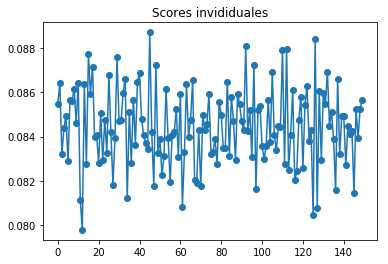

In [29]:
from sklearn.metrics import accuracy_score

preds = np.stack([t.predict(x_val) for t in m.estimators_])
accs = [accuracy_score(y_val==2, p) for p in preds]
plt.plot(accs, '-o')
plt.title('Scores invididuales');

In [30]:
# Usemos los árboles para obtener una predicción con una estimación de confianza.
sample = x_val.sample(1)

pred = np.stack([t.predict(sample) for t in m.estimators_])

pred.mean(), pred.mean() > 0.5, pred.std()

(2.18, True, 0.5665097822044499)

### Predicción

Fuente: https://chrisalbon.com/machine_learning/trees_and_forests/random_forest_classifier_example/

In [31]:
features = df_decks.columns[:6]

features

Index(['deck_class', 'craft_cost', 'avg_mana', 'nminions', 'nspells',
       'nweapons'],
      dtype='object')

In [32]:
m.predict_proba(x_train[features])[0:10]

array([[0.        , 0.00666667, 0.97584127, 0.01749206, 0.        ],
       [0.02005556, 0.008     , 0.39306421, 0.57421356, 0.00466667],
       [0.00222222, 0.0192381 , 0.79933333, 0.17920635, 0.        ],
       [0.        , 0.        , 0.        , 0.00133333, 0.99866667],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.99777778, 0.        , 0.        , 0.00222222, 0.        ],
       [0.07151587, 0.08894444, 0.10011905, 0.71180952, 0.02761111],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.51173403, 0.        , 0.45202788, 0.0362381 , 0.        ]])

In [ ]:
#Guardado de predición en disco
import pickle
filename = 'finalized_model.sav'
pickle.dump(m, open(filename, 'wb'))

Ahora trabajaremos con la data no clasificada

In [33]:
willLabel.head(8)

,deck_class,craft_cost,avg_mana,nminions,nspells,nweapons,deck_archetype
0,2,0,3.066667,12,18,0,Unknown
1,5,5180,2.600000,12,18,0,Unknown
2,0,6260,3.900000,18,12,0,Unknown
6,2,960,2.000000,14,16,0,Unknown
7,3,8640,5.000000,25,4,1,Unknown
8,2,7920,3.733333,20,10,0,Unknown
9,3,7520,4.533333,18,10,2,Unknown
10,0,10240,5.066667,22,8,0,Unknown


In [34]:
archetype_predicted = m.predict(willLabel[features])
archetype_predicted[0:10]

array([4, 1, 3, 4, 2, 4, 3, 2, 2, 4], dtype=int8)

In [35]:
m.predict_proba(willLabel[features])[0:10]

array([[0.        , 0.00666667, 0.00166667, 0.00266667, 0.989     ],
       [0.        , 0.73356878, 0.02811905, 0.        , 0.23831217],
       [0.        , 0.        , 0.25349206, 0.55960317, 0.18690476],
       [0.06380159, 0.        , 0.        , 0.04666667, 0.88953175],
       [0.00228571, 0.        , 0.98596825, 0.01174603, 0.        ],
       [0.        , 0.        , 0.42478042, 0.        , 0.57521958],
       [0.00666667, 0.        , 0.29360317, 0.68973016, 0.01      ],
       [0.        , 0.01333333, 0.58135426, 0.00827778, 0.39703463],
       [0.        , 0.00133333, 0.99866667, 0.        , 0.        ],
       [0.        , 0.        , 0.3312381 , 0.17345238, 0.49530952]])

In [36]:
#Reemplazo de etiqueta desconocida por etiqueta de diccionario
willLabel['deck_archetype'] = archetype_predicted
archetype_predicted = willLabel['deck_archetype']
willLabel['deck_archetype'] = willLabel['deck_archetype'].replace(cat_dict_arch['deck_archetype'])

In [37]:
willLabel.head(10)

,deck_class,craft_cost,avg_mana,nminions,nspells,nweapons,deck_archetype
0,2,0,3.066667,12,18,0,Tempo
1,5,5180,2.600000,12,18,0,Combo
2,0,6260,3.900000,18,12,0,Midrange
6,2,960,2.000000,14,16,0,Tempo
7,3,8640,5.000000,25,4,1,Control
8,2,7920,3.733333,20,10,0,Tempo
9,3,7520,4.533333,18,10,2,Midrange
10,0,10240,5.066667,22,8,0,Control
11,4,6580,3.733333,18,12,0,Control
12,0,8020,4.566667,15,15,0,Tempo
